# **Быстрый код**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# Загрузка тренировочных данных из открытого датасета
training_data = datasets.FashionMNIST(
    root="data",                               # ссылка на данные
    train=True,                                # тренировочный набор = правда
    download=True,                             # загрузить? Да
    transform=ToTensor(),                      # сделать из картинки тензор? Да
)



# Загрузка тестовых данных из открытого датасета
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
test_data[15]

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True,drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True,drop_last=True)

# drop_last=True - удаляет последний блок не кратный пакету

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# N - объем пакета
# С - количество каналов
# H - высота тензора
# W - ширина тензора

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # используем cuda
print(f"Using {device} device")

Using cuda device


In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()                  # делает из массива 28х28 массив 1х784
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),                   # выполняет линейное преобразование входных данных
            nn.ReLU(),                               # все отрицательные числа преаращаются в 0
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300931  [    0/60000]
loss: 2.295123  [ 6400/60000]
loss: 2.285881  [12800/60000]
loss: 2.270977  [19200/60000]
loss: 2.251817  [25600/60000]
loss: 2.234915  [32000/60000]
loss: 2.225264  [38400/60000]
loss: 2.215052  [44800/60000]
loss: 2.186291  [51200/60000]
loss: 2.169681  [57600/60000]
Test Error: 
 Accuracy: 47.3%, Avg loss: 2.169563 

Epoch 2
-------------------------------
loss: 2.163629  [    0/60000]
loss: 2.138363  [ 6400/60000]
loss: 2.131533  [12800/60000]
loss: 2.122550  [19200/60000]
loss: 2.092856  [25600/60000]
loss: 2.023617  [32000/60000]
loss: 2.012382  [38400/60000]
loss: 1.974625  [44800/60000]
loss: 1.925705  [51200/60000]
loss: 1.956748  [57600/60000]
Test Error: 
 Accuracy: 57.3%, Avg loss: 1.915264 

Epoch 3
-------------------------------
loss: 1.858627  [    0/60000]
loss: 1.886152  [ 6400/60000]
loss: 1.877423  [12800/60000]
loss: 1.814303  [19200/60000]
loss: 1.739179  [25600/60000]
loss: 1.737754  [32000/600

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


_____________________________________________________________________________

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


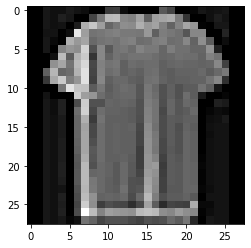

Label: 0


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
train_features[0]

In [ ]:
for i,j in test_dataloader:
  print (i[0],j[0])

In [ ]:
# просмотр_загруженных_данных
for idx, (data, target) in enumerate(train_dataloader):
    print(data[0])
    print(target[0])
    break

В приведенном выше коде мы напечатали первый элемент первого пакета, получив доступ к содержащимся в нем данным и его цели. Данные были усечены для экономии места. Примечание: обычно скрипт не используетbreak ключевое слово – это делается только для того, чтобы предотвратить печать всего.

# **Создание моделей**

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# **Оптимизация параметров модели**

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

# **Сохранение модели**

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# **Загрузка модели**

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

# **ПРОГНОЗЫ**

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Coat", Actual: "Ankle boot"


In [ ]:
# Loading the MNIST Dataset Using PyTorch
# Importing Libraries
from torchvision.datasets import MNIST

# Downloading and Saving MNIST
data_train = MNIST('~/mnist_data', train=True, download=True, transform=ToTensor())

# Print Data
# Dataset MNIST
#     Number of datapoints: 60000
#     Root location: /Users/nikpi/mnist_data
#     Split: Train
#     StandardTransform
# Transform: ToTensor()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/mnist_data/MNIST/raw



In [ ]:
data_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: /root/mnist_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
data_train[0]

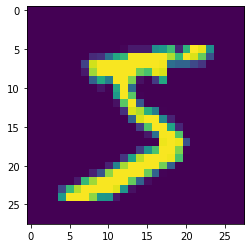

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_train.data[0])
plt.show()

In [ ]:
# Creating a Training DataLoader Object
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Downloading and Saving MNIST
data_train = MNIST('~/mnist_data', train=True, download=True, transform=ToTensor())

# Creating Data Loader
data_loader = DataLoader(data_train, batch_size=20, shuffle=True)

print(data_loader)

In [ ]:
# Loading the First Batch and Printing Information
for idx, batch in enumerate(data_loader):
    print('Batch index: ', idx)
    print('Batch size: ', batch[0].size())
    print('Batch label: ', batch[1])
    break

# Returns:
# Batch index:  0
# Batch size:  torch.Size([20, 1, 28, 28])
# Batch label:  tensor([3, 3, 7, 7, 2, 4, 7, 2, 1, 8, 3, 3, 9, 3, 2, 3, 5, 0, 6, 8])

Batch index:  0
Batch size:  torch.Size([20, 1, 28, 28])
Batch label:  tensor([9, 3, 6, 9, 0, 9, 4, 4, 5, 6, 9, 6, 1, 2, 7, 1, 6, 0, 9, 3])


In [ ]:
# Accessing Data and Targets in a PyTorch DataLoader
for idx, (data, target) in enumerate(data_loader):
    print(data[0])
    print(target[0])
    break

# Returns:
# tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
# ...
#           0.0000, 0.0000, 0.0000, 0.0000]]])
# tensor(1)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
# Loading Data to a GPU with a PyTorch DataLoader Object
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch

data_train = MNIST('~/mnist_data', train=True, download=True, transform=transforms.ToTensor())
data_loader = DataLoader(data_train, batch_size=20, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for idx, (data, target) in enumerate(data_loader):
    data = data.to(device)
    target = target.to(device)